# calculate genome-wide pi (and eventally replot fig X)

## sch_man_nwinvasion


will need to run in the sch_man_nwinvasion-postproc env.

In [1]:
#run in sch_man_nwinvasion-jupyter environment

import os
import shutil
import allel
import math
import yaml
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from scipy import stats
import itertools
import scipy.spatial
import random
from tqdm.notebook import tqdm

In [145]:
os.chdir("/master/nplatt/sch_man_nwinvasion")

if not os.path.exists("results/windowed_pi"):
    os.mkdir("results/windowed_pi")

Calculate the cumulative length fo each chromosome for downstream plotting

# Read in and process data

 Get population assignments

In [3]:
with open('data/pop_assign.yml') as yaml_file:
    pop_assign = yaml.load(yaml_file, Loader=yaml.FullLoader)

read in the vcf file and get pop specific allele counts

In [4]:
#-------------------------------------------------------------------------------
# get genotype info per population

#read in vcf
filtered_callset=allel.read_vcf('results/variant_filtration/smv7_ex_autosomes.vcf')

#now get an index for each sample/population
samples = filtered_callset["samples"]

i=0
pop_idxs = defaultdict(list)   
for sample in samples:  
    pop_idxs[pop_assign[sample]].append(i) 
    i=i+1

pops= list(pop_idxs.keys()) 

#get genotypes
gt=allel.GenotypeArray(filtered_callset['calldata/GT'])

#now get allele count per population
ac=gt.count_alleles()

pop_ac={}
for pop in pops:
    pop_ac[pop] = gt.count_alleles(subpop=pop_idxs[pop])

Find all of the accessible bases (since used probes) and get an idea of the length of each chr

In [5]:
#initialize an list the lenght of each contig to fale
accessible_bases = {}
chrom_length = {}

with open('data/genomes/Smansoni_v7.fa.fai', 'r') as fai:
    for entry in fai:
        chrom, length, *offset = entry.rstrip().split("\t")
        chrom_length[chrom] = int(length)
        accessible_bases[chrom]=[False] * int(length)


#now read the bed
with open('data/renamed-sma_agilent_baits.v7.0.chr_reorderd.bed', 'r') as in_bed_file:
    for bed_entry in in_bed_file:
        chrom, start, stop = bed_entry.rstrip().split("\t")
        for base in range(int(start) - 1, int(stop)):
             accessible_bases[chrom][base]=True


In [6]:
#make sure that all stops are not gt chrom length
chr_length = {}
#genome_size = 0
with open('/master/nplatt/sch_man_nwinvasion/data/genomes/Smansoni_v7.fa.fai', 'r') as fai:
    for entry in fai:
        chrom, length, *offset = entry.rstrip().split("\t")
        chr_length[chrom]=int(length)

    cumul_start={}
    cumul_start['SM_V7_1']=0
    cumul_start['SM_V7_2']= cumul_start['SM_V7_1'] + chr_length['SM_V7_1']
    cumul_start['SM_V7_3']= cumul_start['SM_V7_2'] + chr_length['SM_V7_2']
    cumul_start['SM_V7_4']= cumul_start['SM_V7_3'] + chr_length['SM_V7_3']
    cumul_start['SM_V7_5']= cumul_start['SM_V7_4'] + chr_length['SM_V7_4']
    cumul_start['SM_V7_6']= cumul_start['SM_V7_5'] + chr_length['SM_V7_5']
    cumul_start['SM_V7_7']= cumul_start['SM_V7_6'] + chr_length['SM_V7_6']
    scanned_size = cumul_start['SM_V7_7'] + chr_length['SM_V7_7']

# Pi

In [151]:
#set window size
window_size = 100_000

#get chrom and pos values from vcf file 
pos=filtered_callset["variants/POS"]
chroms=filtered_callset["variants/CHROM"]

for pop in ["niger", "senegal", "brazil", "tanzania"]:
    
    #initialize empty lists for values to be saved
    pis=[]
    starts=[]
    stops=[]
    bases=[]
    snvs=[]
    chrom_labels=[]

    for chrom in np.unique(filtered_callset["variants/CHROM"]):
        #subset the positions and allele counts for each chrom
        #  makes sure to restrict calculations along a single chrom rather
        #  than windows extending over 2 chroms
        sub_pos = pos[chroms==chrom] 
        sub_ac  = pop_ac[pop][chroms==chrom] 
        
        #calculate pi over "window" bases
        pi, window, base, snv = allel.windowed_diversity(sub_pos, sub_ac, size=window_size, is_accessible=accessible_bases[chrom])
        
        #append values for each stat
        pis=np.hstack((pis, pi))
        starts=np.hstack((starts, window[:,0]))
        stops=np.hstack((stops, window[:,0]))
        bases=np.hstack((bases, base))
        snvs=np.hstack((snvs, snv))
        chrom_labels.extend([chrom] * len(pi))

    #add values to a data frame
    pi_df=pd.DataFrame(columns=["chrom", "start", "stop", "pi", "n_access_bases", "n_vars"])
    pi_df["chrom"]=chrom_labels
    pi_df["start"]=starts
    pi_df["stop"]=stops
    pi_df["pi"]=pis
    pi_df["n_access_bases"]=bases
    pi_df["n_vars"]=snvs
    
    #save the dataframe to a csv
    csv_file = "./results/windowed_pi/{}_windowed_pi.csv".format(pop)
    pi_df.to_csv(csv_file, index=False, header=True, mode='w')

# Plot selection results

In [426]:
colors={ "SM_V7_1": "silver",
         "SM_V7_2": "black",
         "SM_V7_3": "silver",
         "SM_V7_4": "black",
         "SM_V7_5": "silver",
         "SM_V7_6": "black",
         "SM_V7_7": "silver",
         "sig":     "blue"
       }

In [76]:
plt.scatter(pis["niger"])

TypeError: scatter() missing 1 required positional argument: 'y'

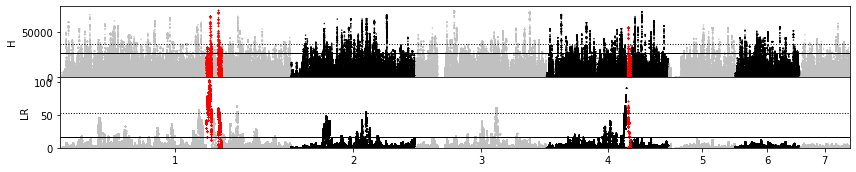

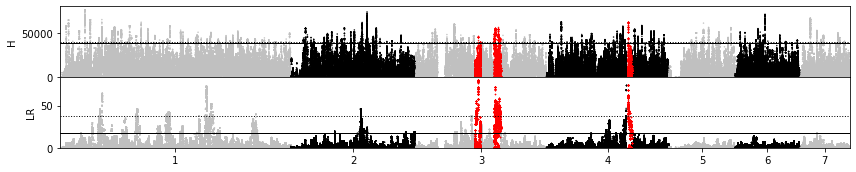

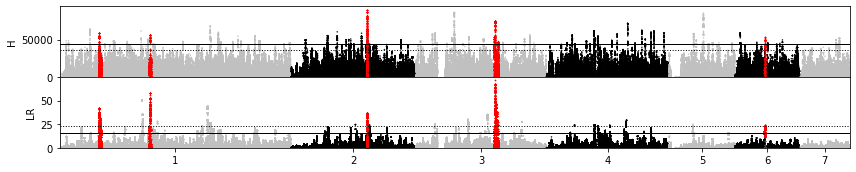

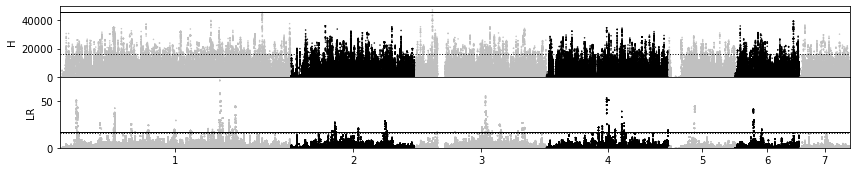

In [428]:
for pop in ["niger", "senegal", "brazil", "tanzania"]:

    fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0}, figsize=(12, 2.5))

    csv_file = "./results/selection_peaks/{}_snp_data.csv".format(pop)
    df=pd.read_csv(csv_file, sep=",")
    
    #get chrom based colors and (temp add to df)
    marker_colors=[]
    for index, row in df.iterrows():
        color = colors[row["chrom"]]
        marker_colors.append(color)
        
    df.insert(len(df.columns),'color', marker_colors)
    
    #no extract sig and non sig snps
    tar_df=df[df["target_region"]==True]
    non_df=df[df["target_region"]==False]
    
    #plot each seperatley
    axs[0].scatter(non_df["fig_x_pos"], non_df["h"],  marker =".", s = 1, c = non_df['color'])
    axs[1].scatter(non_df["fig_x_pos"], non_df["lr"], marker =".", s = 1, c = non_df['color'])
    axs[0].scatter(tar_df["fig_x_pos"], tar_df["h"],  marker =".", s = 1, c = "red")
    axs[1].scatter(tar_df["fig_x_pos"], tar_df["lr"], marker =".", s = 1, c = "red")

    #set axes
    axs[0].set_xlim((0,scanned_size))
    axs[0].set_ylim((0,max(np.append(df['h'], max_h[pop])*1.05)))
    axs[1].set_ylim((0,max(np.append(df['lr'], max_lr[pop])*1.05)))
                    
    tick_lbls = [ "1", "2", "3", "4", "5", "6" ,"7"]
    plt.setp(axs, xticks=ticks, xticklabels=tick_lbls)
    axs[0].set(ylabel="H")
    axs[1].set(ylabel="LR")
    axs[0].ticklabel_format(axis='y', style='sci')


    #draw lines at...
    #...the max simulated value
    axs[0].axhline(y=max_h[pop],  color="black", linewidth=1)
    axs[1].axhline(y=max_lr[pop], color="black", linewidth=1)

    #...the 99th percentile
    axs[0].axhline(y=np.percentile(df['smoothed_h'],  target_percentile*100), linestyle=":",  color="black", linewidth=1)
    axs[1].axhline(y=np.percentile(df['lr'], target_percentile*100), linestyle=":", color="black", linewidth=1)
    
    #set the title
    #title="{}".format(pop.title())
    #fig.suptitle(title)

    plt.tight_layout()
    fig.savefig("results/selection_peaks/{}_selection.png".format(pop), dpi=300)
    fig.savefig("results/selection_peaks/{}_selection.svg".format(pop)) 
    plt.show()
    plt.close()

# Explore regions under selection

In [432]:
with open('results/selection_peaks/peaks.bed', 'w') as outfile:
    for pop in ["niger", "senegal", "brazil", "tanzania"]:
        with open( "results/selection_peaks/{}_target_regions.bed".format(pop), 'r') as infile:
            for entry in infile:
                entry=entry.rstrip()
                outfile.write("{}\t{}\n".format(entry, pop))

sig_regions_bed = pybedtools.BedTool('results/selection_peaks/peaks.bed')
print(sig_regions_bed)

SM_V7_1	56295674	58355356	niger
SM_V7_1	60733736	62145588	niger
SM_V7_4	31216154	32138352	niger
SM_V7_3	22786583	24999268	senegal
SM_V7_3	30092830	32970510	senegal
SM_V7_4	31216154	32881663	senegal
SM_V7_1	14832351	15772979	brazil
SM_V7_1	34234733	35105276	brazil
SM_V7_2	29220788	29604570	brazil
SM_V7_3	30092830	31936551	brazil
SM_V7_6	11468141	11631927	brazil



In [433]:
#avg peak size 
size=0
for chrom, start, stop, pop in sig_regions_bed:
    size+=int(stop)-int(start)+1

avg_size=size/len(sig_regions_bed)

print("avg peak size is {:.1f} bp".format(avg_size))

avg peak size is 1395643.4 bp


In [525]:
#intersect peaks wtih gff
gff = pybedtools.BedTool('data/genomes/Sm_v7.0.gff')

#intersecting_genes["brazil"]["snps"]=["gene1", "gene2"]
intersecting_genes=defaultdict(lambda: defaultdict(list))

#excluding tanzania cause there are no sig snps in that pop
for pop in ["niger", "senegal", "brazil"]:

    #intersect target regions with the genes gff
    regions_bed = pybedtools.BedTool("results/selection_peaks/{}_target_regions.bed".format(pop))
    intersect_regions_gff = gff.intersect(regions_bed, u=True)
    intersect_regions_gff.saveas("./results/selection_peaks/{}_target_regions_vs_genes.gff".format(pop))

    #intersect target SNPs with the genes gff
    sig_snps_bed = pybedtools.BedTool("results/selection_peaks/{}_sig_snps.bed".format(pop))
    intersect_snps_gff = gff.intersect(sig_snps_bed, u=True)
    intersect_snps_gff.saveas("./results/selection_peaks/{}_sig_snps_vs_genes.gff".format(pop))

    #create a gff database of genes intersecting target regions
    region_db = gffutils.create_db("./results/selection_peaks/{}_target_regions_vs_genes.gff".format(pop), 
                                    dbfn="results/selection_peaks/{}_target_regions_vs_genes.gff.db".format(pop),
                                    force=True, 
                                    keep_order=True, 
                                    merge_strategy='merge', 
                                    sort_attribute_values=True)

    #create a gff database of genes intersecting target genes
    snp_db = gffutils.create_db("./results/selection_peaks/{}_sig_snps_vs_genes.gff".format(pop), 
                            dbfn="results/selection_peaks/{}_sig_snps_vs_genes.gff.db".format(pop),
                            force=True, 
                            keep_order=True, 
                            merge_strategy='merge', 
                            sort_attribute_values=True)
    
    
    
    
    for i in region_db.features_of_type('gene'):
        intersecting_genes[pop]["region"].append(i["ID"][0])
    
    for i in snp_db.features_of_type('gene'):
        intersecting_genes[pop]["snp"].append(i["ID"][0])

/master/nplatt/miniconda3/envs/sch_man_nwinvasion-jupyter/lib/python3.8/subprocess.py:849: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)
/master/nplatt/miniconda3/envs/sch_man_nwinvasion-jupyter/lib/python3.8/subprocess.py:849: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)
/master/nplatt/miniconda3/envs/sch_man_nwinvasion-jupyter/lib/python3.8/subprocess.py:849: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)
/master/nplatt/miniconda3/envs/sch_man_nwinvasion-jupyter/lib/python3.8/subprocess.py:849: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb

In [570]:
with open ("results/selection_peaks/snp_genes_table.tsv", 'w') as snp_outfile:
    with open ("results/selection_peaks/region_genes_table.tsv", 'w') as region_outfile:

        for pop in ["niger", "senegal", "brazil"]:
            num_snp_genes    = str(len(intersecting_genes[pop]["snp"]))
            num_region_genes = str(len(intersecting_genes[pop]["region"]))
            print("{}: {} and {} genes in target regions and with target snps".format(pop, num_region_genes, num_snp_genes))

            intersecting_genes[pop]["snp"].sort()
            outline="\n".join([pop] + intersecting_genes[pop]["snp"])
            snp_outfile.write(outline + "\n")
        
            intersecting_genes[pop]["region"].sort()
            outline="\n".join([pop] + intersecting_genes[pop]["region"])
            region_outfile.write(outline + "\n")

niger: 121 and 5 genes in target regions and with target snps
senegal: 175 and 7 genes in target regions and with target snps
brazil: 126 and 10 genes in target regions and with target snps


In [542]:
pop_combos=list(itertools.combinations(["brazil", "senegal", "niger"], 2)) 

for pop1, pop2 in pop_combos:
    pop1_genes=set(intersecting_genes[pop1]["snp"])
    pop2_genes=set(intersecting_genes[pop2]["snp"])
    
    shared_genes=pop1_genes.intersection(pop2_genes)
    print("{} v {}: {} genes, {}".format(pop1, 
                                         pop2, 
                                         str(len(shared_genes)), 
                                         str(shared_genes)))

brazil v senegal: 1 genes, {'Smp_123520'}
brazil v niger: 0 genes, set()
senegal v niger: 2 genes, {'Smp_313490', 'Smp_167890'}


In [543]:
for pop1, pop2 in pop_combos:
    pop1_genes=set(intersecting_genes[pop1]["region"])
    pop2_genes=set(intersecting_genes[pop2]["region"])
    
    shared_genes=pop1_genes.intersection(pop2_genes)
    print("{} v {}: {} genes, {}".format(pop1, 
                                         pop2, 
                                         str(len(shared_genes)), 
                                         str(shared_genes)))

brazil v senegal: 50 genes, {'Smp_123460', 'Smp_212320', 'Smp_123480', 'Smp_123490', 'Smp_078750', 'Smp_300810', 'Smp_002860', 'Smp_164590', 'Smp_347390', 'Smp_123470', 'Smp_165280', 'Smp_123440', 'Smp_002510', 'Smp_337740', 'Smp_197370', 'Smp_002640', 'Smp_123500', 'Smp_123610', 'Smp_123670', 'Smp_123510', 'Smp_123590', 'Smp_002740', 'Smp_123570', 'Smp_123620', 'Smp_123640', 'Smp_002550', 'Smp_123450', 'Smp_123690', 'Smp_002840', 'Smp_002600', 'Smp_123600', 'Smp_002880', 'Smp_164560', 'Smp_084520', 'Smp_341880', 'Smp_002920', 'Smp_123530', 'Smp_308820', 'Smp_202130', 'Smp_078730', 'Smp_202120', 'Smp_002870', 'Smp_326390', 'Smp_123630', 'Smp_308830', 'Smp_021340', 'Smp_123520', 'Smp_345510', 'Smp_084540', 'Smp_002820'}
brazil v niger: 0 genes, set()
senegal v niger: 24 genes, {'Smp_114565', 'Smp_266770', 'Smp_093840', 'Smp_334280', 'Smp_174630', 'Smp_332080', 'Smp_310500', 'Smp_169520', 'Smp_169530', 'Smp_095650', 'Smp_204980', 'Smp_093850', 'Smp_180240', 'Smp_345890', 'Smp_341620', 'S

## Pi in regions of interest vs. others.

In [14]:
#read in bed file
sig_regions_bed_df = pd.read_table('results/selection_peaks/peaks.bed', sep="\t", header=None)
sig_regions_bed_df.columns=["chrom", "start", "stop", "pop"]
sig_regions_bed_df

,chrom,start,stop,pop
0,SM_V7_1,56295674,58355356,niger
1,SM_V7_1,60733736,62145588,niger
2,SM_V7_4,31216154,32138352,niger
3,SM_V7_3,22786583,24999268,senegal
4,SM_V7_3,30092830,32970510,senegal
5,SM_V7_4,31216154,32881663,senegal
6,SM_V7_1,14832351,15772979,brazil
7,SM_V7_1,34234733,35105276,brazil
8,SM_V7_2,29220788,29604570,brazil
9,SM_V7_3,30092830,31936551,brazil


In [10]:
with open('data/pop_assign.yml') as yaml_file:
    pop_assign = yaml.load(yaml_file, Loader=yaml.FullLoader)

In [11]:
#-------------------------------------------------------------------------------
# get genotype info per population

#read in vcf
filtered_callset=allel.read_vcf('results/variant_filtration/smv7_ex_autosomes.vcf')

#now get an index for each sample/population
samples = filtered_callset["samples"]

i=0
pop_idxs = defaultdict(list)   
for sample in samples:  
    pop_idxs[pop_assign[sample]].append(i) 
    i=i+1

pops= list(pop_idxs.keys()) 

#get genotypes
gt=allel.GenotypeArray(filtered_callset['calldata/GT'])

#now get allele count per population
ac=gt.count_alleles()

pop_ac={}
for pop in pops:
    pop_ac[pop] = gt.count_alleles(subpop=pop_idxs[pop])

In [12]:
#initialize an list the lenght of each contig to fale
accessible_bases = {}
chrom_length = {}

with open('data/genomes/Smansoni_v7.fa.fai', 'r') as fai:
    for entry in fai:
        chrom, length, *offset = entry.rstrip().split("\t")
        chrom_length[chrom] = int(length)
        accessible_bases[chrom]=[False] * int(length)


#now read the bed
with open('data/renamed-sma_agilent_baits.v7.0.chr_reorderd.bed', 'r') as in_bed_file:
    for bed_entry in in_bed_file:
        chrom, start, stop = bed_entry.rstrip().split("\t")
        for base in range(int(start) - 1, int(stop)):
             accessible_bases[chrom][base]=True


In [22]:
type(stop)

int

In [34]:
pi_s=[]
#accessible_base_count_s=[]

for index, row in sig_regions_bed_df.iterrows():
    chrom =row["chrom"]
    start = row["start"]
    stop  = row["stop"]
    
    #calculate pi
    test_ac  = pop_ac[pop][filtered_callset['variants/CHROM'] == chrom]
    test_pos = filtered_callset['variants/POS'][filtered_callset['variants/CHROM'] == chrom]
    test_acc = accessible_bases[chrom]
    
    pi = allel.sequence_diversity(test_pos, 
                                  test_ac, 
                                  start=start, 
                                  stop=stop, 
                                  is_accessible=test_acc)
    pi_s.append(pi)
    #np.sum(test_acc[start:stop]) 

sig_regions_bed_df["pi"]=pi_s
sig_regions_bed_df

,chrom,start,stop,pop,pi
0,SM_V7_1,56295674,58355356,niger,0.001018
1,SM_V7_1,60733736,62145588,niger,0.000574
2,SM_V7_4,31216154,32138352,niger,0.000918
3,SM_V7_3,22786583,24999268,senegal,0.001378
4,SM_V7_3,30092830,32970510,senegal,0.001052
5,SM_V7_4,31216154,32881663,senegal,0.001094
6,SM_V7_1,14832351,15772979,brazil,0.000965
7,SM_V7_1,34234733,35105276,brazil,0.000592
8,SM_V7_2,29220788,29604570,brazil,0.001077
9,SM_V7_3,30092830,31936551,brazil,0.001184
